In [1]:
#%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import math, gillespy2
from gillespy2.solvers.cpp.ssa_c_solver import SSACSolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver
from scipy import stats

In [2]:
class DayModel(gillespy2.Model):
    def __init__(self, parameter_values=None, init_v=0, spore=1.61e9, macrophage=1e6):
        # initialize
        gillespy2.Model.__init__(self, name="Macrophage")
        
        # species
        #S_ = gillespy2.Species(name='S_', initial_value=3.256e6) # low = 4e3; mid = 2e4; high = 1e7
        S_ = gillespy2.Species(name='S_', initial_value=spore) # low = 4e3; mid = 2e4; high = 1e7
        
        #A_ = gillespy2.Species(name='A_', initial_value=1e6) # A = Sa/(k2*S+MuA)
        A_ = gillespy2.Species(name='A_', initial_value=macrophage) # A = Sa/(k2*S+MuA)
        
        H1 = gillespy2.Species(name='H1', initial_value=0)
        H2 = gillespy2.Species(name='H2', initial_value=0)
        H3 = gillespy2.Species(name='H3', initial_value=0)
        H4 = gillespy2.Species(name='H4', initial_value=0)
        H5 = gillespy2.Species(name='H5', initial_value=0)
        H6 = gillespy2.Species(name='H6', initial_value=0)
        
        HLN1 = gillespy2.Species(name='HLN1', initial_value=0)
        HLN2 = gillespy2.Species(name='HLN2', initial_value=0)
        HLN3 = gillespy2.Species(name='HLN3', initial_value=0)
        HLN4 = gillespy2.Species(name='HLN4', initial_value=0)
        HLN5 = gillespy2.Species(name='HLN5', initial_value=0)
        HLN6 = gillespy2.Species(name='HLN6', initial_value=0)
        
        self.add_species([S_,A_,H1,H2,H3,H4,H5,H6,HLN1,HLN2,HLN3,HLN4,HLN5,HLN6])
        
        # parameters        
        # rate of phagocytosis
        k2 = gillespy2.Parameter(name='k2', expression=1e-10)
        
        # migration to TMLN
        k3 = gillespy2.Parameter(name='k3', expression=0.05)
        
        self.add_parameter([k2,k3])
        
        # reactions
        R1 = gillespy2.Reaction(
            name='R1',
            reactants={S_:1, A_:1},
            products={H1:1},
            rate=k2
        )
        
        R2 = gillespy2.Reaction(
            name='R2',
            reactants={S_:1, H1:1},
            products={H2:1},
            rate=k2
        )
        
        R3 = gillespy2.Reaction(
            name='R3',
            reactants={S_:1, H2:1},
            products={H3:1},
            rate=k2
        )
        
        R4 = gillespy2.Reaction(
            name='R4',
            reactants={S_:1, H3:1},
            products={H4:1},
            rate=k2
        )
        
        R5 = gillespy2.Reaction(
            name='R5',
            reactants={S_:1, H4:1},
            products={H5:1},
            rate=k2
        )
        
        R6 = gillespy2.Reaction(
            name='R6',
            reactants={S_:1, H5:1},
            products={H6:1},
            rate=k2
        )
        
        # To the lung
        R7 = gillespy2.Reaction(
            name='R7',
            reactants={H1:1},
            products={HLN1:1},
            rate=k3
        )
        
        R8 = gillespy2.Reaction(
            name='R8',
            reactants={H2:1},
            products={HLN2:1},
            rate=k3
        )
        
        R9 = gillespy2.Reaction(
            name='R9',
            reactants={H3:1},
            products={HLN3:1},
            rate=k3
        )
        
        R10 = gillespy2.Reaction(
            name='R10',
            reactants={H4:1},
            products={HLN4:1},
            rate=k3
        )
        
        R11 = gillespy2.Reaction(
            name='R11',
            reactants={H5:1},
            products={HLN5:1},
            rate=k3
        )
        
        R12 = gillespy2.Reaction(
            name='R12',
            reactants={H6:1},
            products={HLN6:1},
            rate=k3
        )
                
        self.add_reaction([R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12])
        t = numpy.linspace(0,200,21)
        self.timespan(t)
        #print(t)

In [3]:
# def get_mean(results):
#     data = []
#     data.extend([1]*int(results['HLN1'][-1]))
#     data.extend([2]*int(results['HLN2'][-1]))
#     data.extend([3]*int(results['HLN3'][-1]))
#     data.extend([4]*int(results['HLN4'][-1]))
#     data.extend([5]*int(results['HLN5'][-1]))
#     data.extend([6]*int(results['HLN6'][-1]))
#     if len(data) != 0:
#         mean = numpy.mean(data)
#     else:
#         mean = 0
#     data=[]
#     return mean

def get_mean(results):
    num =  (
        (1*results['HLN1'][-1]) +
        (2*results['HLN2'][-1]) +
        (3*results['HLN3'][-1]) +
        (4*results['HLN4'][-1]) +
        (5*results['HLN5'][-1]) +
        (6*results['HLN6'][-1])
    )

    div = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    
    weighted_avg = num / div
    return weighted_avg

In [90]:
model = DayModel(macrophage=2.34E+13, spore=4.83E+13)
%time results_orig = model.run(solver=BasicODESolver)
%time mean_of_model = get_mean(results_orig[0])
mean_of_model

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 128 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.8 µs


2.3617225738196956

In [5]:
%%time
results = numpy.zeros((20,20))
sporescale = numpy.logspace(8, 14, 20)
macroscale = numpy.logspace(6, 16, 20)

for i,s in enumerate(sporescale):
    for j,a in enumerate(macroscale):
        model = DayModel(spore=s, macrophage=a)
        r = model.run(solver=BasicODESolver)
        results[i,j] = get_mean(r[0])

/home/george/.local/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


CPU times: user 50.5 s, sys: 0 ns, total: 50.5 s
Wall time: 51.4 s


[0, 20, 0, 20]

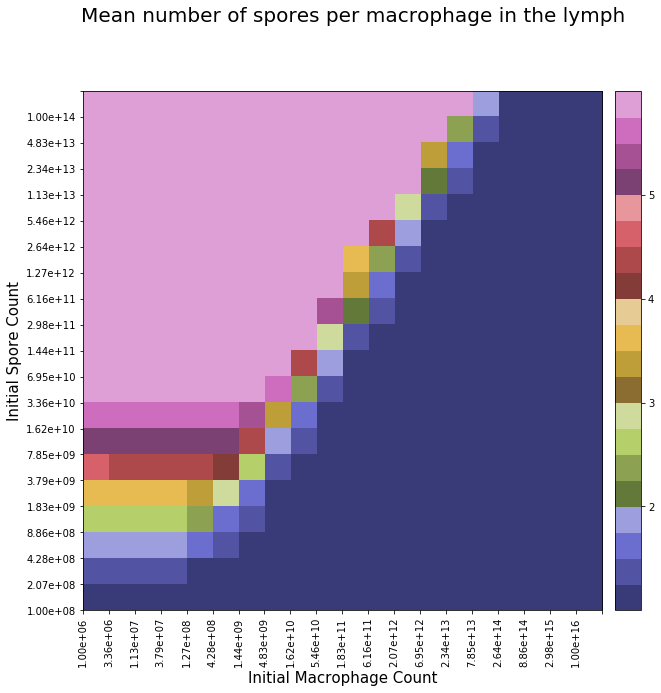

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

x_scale = ['{:.2e}'.format(item) for item in macroscale]
y_scale = ['{:.2e}'.format(item) for item in sporescale]

#fig = plt.figure(figsize=(10,10))
fig,ax = plt.subplots(figsize=(10,10))
fig.suptitle("Mean number of spores per macrophage in the lymph", fontsize=20)
im = plt.imshow(results, cmap='tab20b', interpolation='nearest', extent=[0,20,20,0])

#plt.colorbar()
add_colorbar(im)
plt.xlabel("Initial Macrophage Count", fontsize=15)
plt.ylabel("Initial Spore Count", fontsize=15)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
ticks = numpy.linspace(0,20,21)

plt.xticks(ticks, x_scale, rotation=90)
plt.yticks(ticks, y_scale)
ax.axis([0, 20, 0, 20])

# using log scale doesn't work right
# ax.loglog()
# ax.set_ylim(1e1, 1e9)
# ax.set_xlim(1e1, 1e9)

# print("Spores @ 10: {0:1.2e}".format(sporescale[11]))
# print("Spores @ 20: {0:1.2e}".format(sporescale[19]))
# print("")
# print("Macrophages @ 10: {0:1.2e}".format(macscale[11]))
# print("Macrophages @ 20: {0:1.2e}".format(macscale[19]))

# print("{0:1.2e}".format(sporescale[8]))
# print("{0:1.2e}".format(macscale[8]))
# print(sporescale)
# print(macroscale)
# print("")

# with np.printoptions(formatter={'float': '{: 0.2f}'.format}):
#     i = len(results)-1
#     for r in reversed(results):
#         print('{0}: {1}'.format(i,r)) # use the y-axis from the bottom
#         i=i-1
        


In [89]:
def get_coords(col_index, row_index):
    row = sporescale
    col = macroscale
    position = "{0:.2e}, {1:.2e}".format(col[col_index],row[row_index])
    return position

with np.printoptions(formatter={'float': '{: 0.2e}'.format}):
    print(get_coords(14,18))


2.34e+13, 4.83e+13


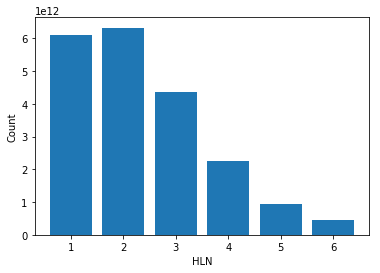

Mean: 	2.3617225738196956


In [95]:
res = results_orig[0]
data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]

# r = results[0]
# data3 = []
# data3.extend([1]*int(res['HLN1'][-1]))
# data3.extend([2]*int(res['HLN2'][-1]))
# data3.extend([3]*int(res['HLN3'][-1]))
# data3.extend([4]*int(res['HLN4'][-1]))
# data3.extend([5]*int(res['HLN5'][-1]))
# data3.extend([6]*int(res['HLN6'][-1]))

# mean = numpy.mean(data3)
# sd = numpy.std(data3)
# sem = stats.sem(data3)

plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

# plt.hist(data3, bins=x,edgecolor="black")
# plt.xlabel('HLN')
# plt.ylabel('Count')
# plt.show()

print("Mean: \t{}".format(get_mean(res)))
# print("STD:  \t{}".format(sd))
# print("SEM:  \t{}".format(sem))

In [8]:
# for i in range(0,len(means)):
#     print("Mean: \t{}".format(means[i]))


In [9]:
# plt.hist2d(range(0, 199), means)
# plt.ylim(3, 5)
# plt.show()

#n,x2,_ = plt.hist(data3,bins=6,edgecolor='black')
#bin_centers = 0.5*(x2[1:]+x2[:-1])
#plt.plot(bin_centers, n)
#plt.show()

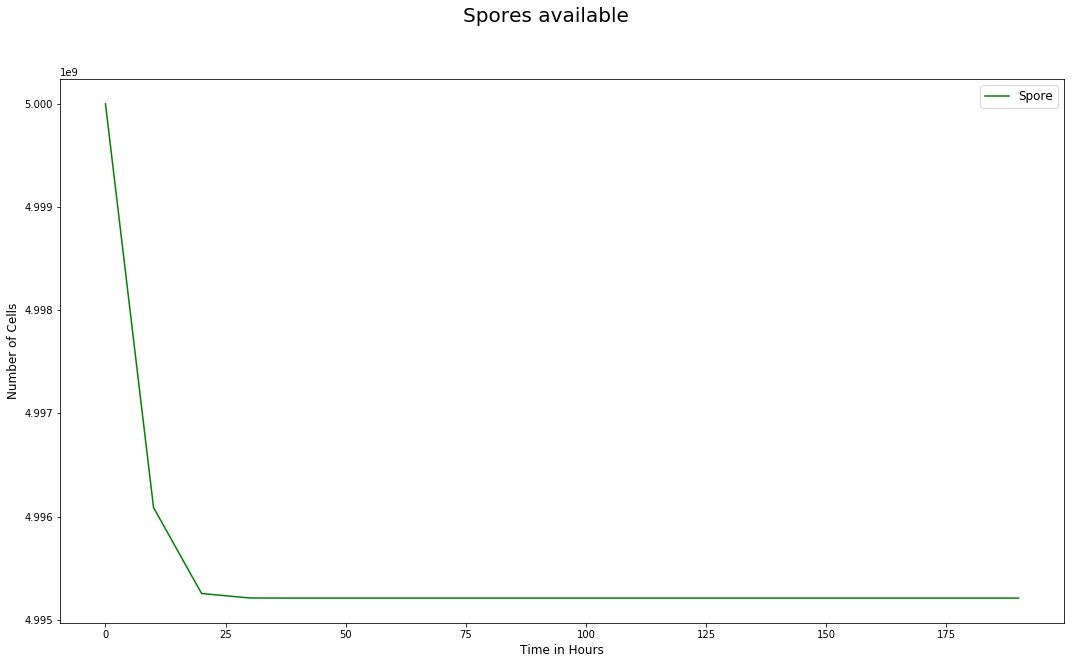

In [10]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(results_orig[0]['time'], results_orig[0]['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
# print("Initial spores: {}".format(results['S_'][0]))
# print("Spores remaining: {}".format(results['S_'][-1]))
# print("Spores at 5 hours: {}".format(results['S_'][100]))


Lung Hosts at end:
H1: 2.570065164414352e-15
H2: 2.1013040069994324e-14
H3: -7.425970762550038e-13
H4: 3.236484576876754e-12
H5: 1.6172839574794707e-11
H6: 83.17061062086812


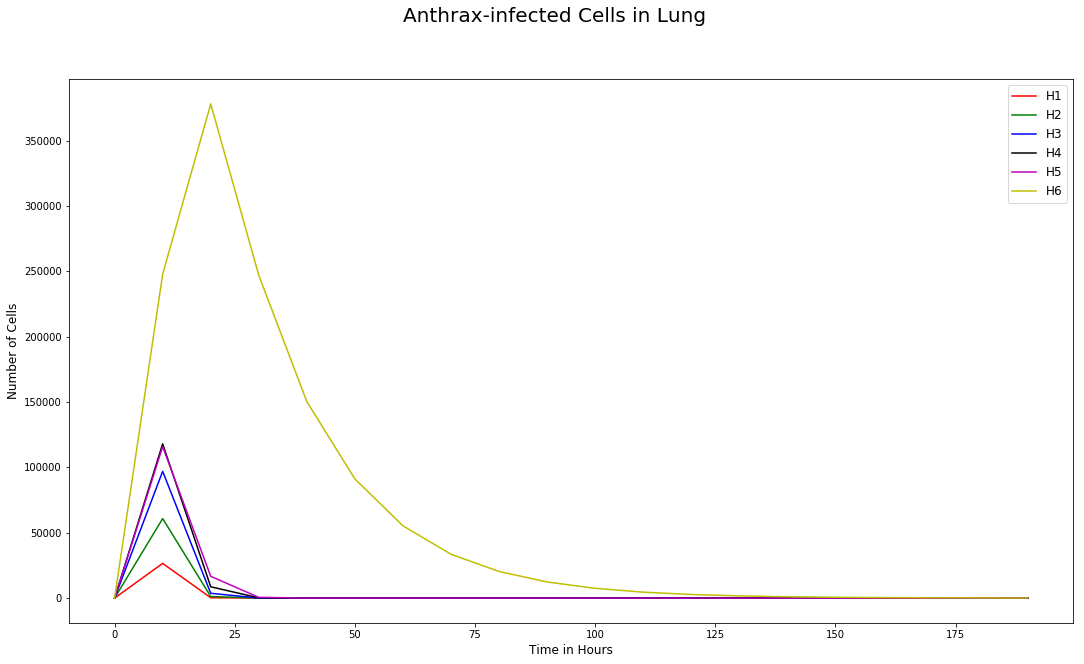

In [11]:
res = results_orig[0]
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))




k2 = 1.00e-10, k3 = 5.00e-02
Lung Hosts at end:
H1: 2.570065164414352e-15
H2: 2.1013040069994324e-14
H3: -7.425970762550038e-13
H4: 3.236484576876754e-12
H5: 1.6172839574794707e-11
H6: 83.17061062086812
Lymph Node Hosts at end:
HLN1: 90937.6049358618
HLN2: 82678.23986579354
HLN3: 75166.62415110867
HLN4: 68335.40937661039
HLN5: 62123.36035713751
HLN6: 620675.5907028675


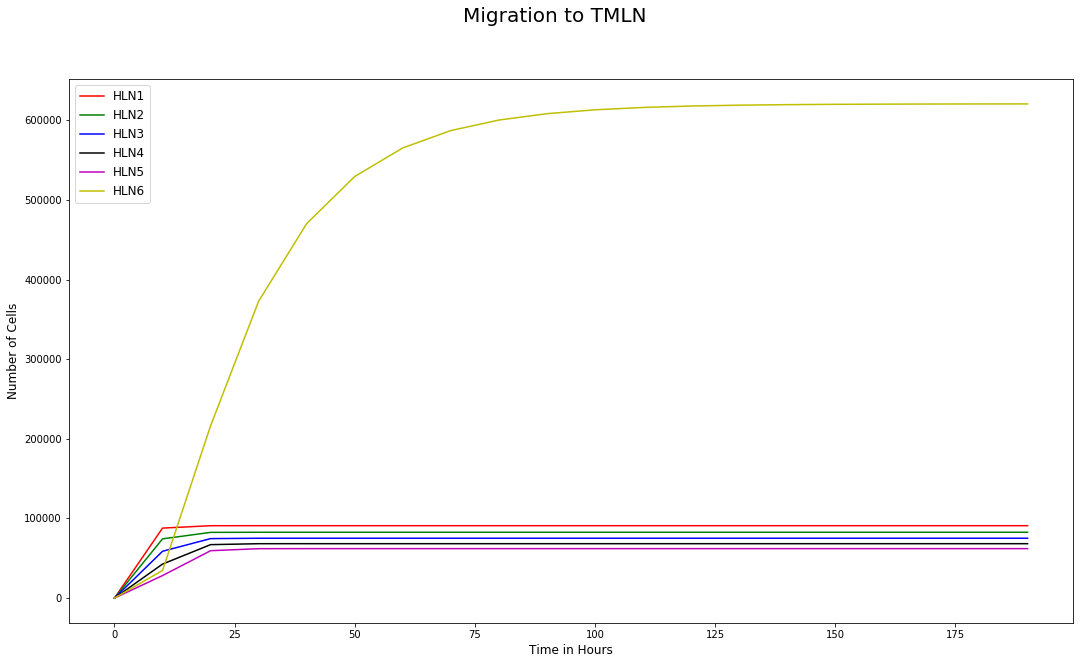

In [12]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)
res = results_orig[0]

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("k2 = {:.2e}, k3 = {:.2e}".format(float(model.listOfParameters['k2'].expression), float(model.listOfParameters['k3'].expression)))

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))

print("Lymph Node Hosts at end:")
print("HLN1: {}".format(res['HLN1'][-1]))
print("HLN2: {}".format(res['HLN2'][-1]))
print("HLN3: {}".format(res['HLN3'][-1]))
print("HLN4: {}".format(res['HLN4'][-1]))
print("HLN5: {}".format(res['HLN5'][-1]))
print("HLN6: {}".format(res['HLN6'][-1]))